This data was acquired from Absent data, https://absentdata.com/data-analysis/where-to-find-data/

Problem:
- Hotel reservation cancellations.

Research question:
- What factors influence hotel reservation cancellations?
- How can hotels improve their reservation processes to reduce cancellation rates and enhance customer satisfaction?
- How can hotels optimize their pricing and promotion strategies to minimize cancellations and maximize revenue?

Assumptions:
- Cancellations happen when prices rise.
- Customers are likely to cancel when lead takes too long.
- Cancellations happen when there is a deposit.

Approach:
- Carry out an analysis to answer the above questions.
- Build a model to predict cancellations.
- Build a forecast model for hotel demand.

<h5> Importing libraries

In [74]:
import pyodbc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#ml
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc, classification_report, log_loss, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

pd.set_option('display.max_columns',None)
import warnings 
warnings.filterwarnings("ignore")

<h5> Connect to the database

In [5]:
# connecting to the sql server
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=DESKTOP-4CBV3OP\sqlexpress;'
                      'Database=project;'
                      'Trusted_Connection=yes;')

hotel_df = pd.read_sql_query(
    '''
with hotels as(select * from dbo.['2018$']
union
select * from dbo.['2019$']
union
select * from dbo.['2020$'])

-- joining hotels with meal cost and market segment table
select hotels.*, dbo.market_segment$.Discount as market_segment_discount, dbo.meal_cost$.Cost as cost_of_meal
from hotels
left join dbo.market_segment$ on hotels.market_segment = dbo.market_segment$.market_segment
left join dbo.meal_cost$ on hotels.meal = dbo.meal_cost$.meal
''', conn)

hotel_df.head(3)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,market_segment_discount,cost_of_meal
0,City Hotel,0.0,0.0,2019.0,February,8.0,15.0,1.0,3.0,1.0,0.0,0.0,BB,PRT,Aviation,TA/TO,0.0,0.0,0.0,A,A,0.0,No Deposit,153.0,NULL,0.0,Transient,88.0,1.0,0.0,Check-Out,2019-02-19,0.2,12.99
1,City Hotel,0.0,0.0,2019.0,July,28.0,8.0,0.0,0.0,1.0,0.0,0.0,BB,PRT,Aviation,Corporate,1.0,0.0,0.0,A,K,0.0,No Deposit,NaN,153,0.0,Transient,0.0,0.0,0.0,Check-Out,2019-07-08,0.2,12.99
2,City Hotel,0.0,0.0,2019.0,July,30.0,20.0,0.0,1.0,1.0,0.0,0.0,BB,GRC,Aviation,Corporate,0.0,0.0,0.0,A,A,0.0,No Deposit,NaN,153,0.0,Transient,79.0,0.0,0.0,Check-Out,2019-07-21,0.2,12.99


<h5> Data exploration and cleaning

In [6]:
# summary of the data
hotel_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100756 entries, 0 to 100755
Data columns (total 34 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   hotel                           100756 non-null  object        
 1   is_canceled                     100756 non-null  float64       
 2   lead_time                       100756 non-null  float64       
 3   arrival_date_year               100756 non-null  float64       
 4   arrival_date_month              100756 non-null  object        
 5   arrival_date_week_number        100756 non-null  float64       
 6   arrival_date_day_of_month       100756 non-null  float64       
 7   stays_in_weekend_nights         100756 non-null  float64       
 8   stays_in_week_nights            100756 non-null  float64       
 9   adults                          100756 non-null  float64       
 10  children                        100748 non-null  float64

- Our dataset has 100756 rows and 34 columns.
- There is presence of nulls in agent, children and company.

Data issues.
- Missing values and incorect data types for some columns.

In [7]:
# confirmig number of nulls
hotel_df.isna().sum()

hotel                                 0
is_canceled                           0
lead_time                             0
arrival_date_year                     0
arrival_date_month                    0
arrival_date_week_number              0
arrival_date_day_of_month             0
stays_in_weekend_nights               0
stays_in_week_nights                  0
adults                                0
children                              8
babies                                0
meal                                  0
country                               0
market_segment                        0
distribution_channel                  0
is_repeated_guest                     0
previous_cancellations                0
previous_bookings_not_canceled        0
reserved_room_type                    0
assigned_room_type                    0
booking_changes                       0
deposit_type                          0
agent                             14539
company                               0


<h5> Dealing with missing values

In [8]:
# Drop columns with nulls
hotel_df1= hotel_df.drop(columns=['agent','company'])
hotel_df1.sample(3)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,market_segment_discount,cost_of_meal
54463,City Hotel,0.0,34.0,2020.0,February,7.0,16.0,2.0,6.0,2.0,0.0,0.0,BB,IND,Online TA,TA/TO,0.0,0.0,0.0,A,A,0.0,No Deposit,0.0,Transient,68.07,0.0,1.0,Check-Out,2020-02-24,0.30,12.99
79180,City Hotel,1.0,181.0,2019.0,October,42.0,11.0,0.0,1.0,1.0,0.0,0.0,SC,FRA,Online TA,TA/TO,0.0,0.0,0.0,A,A,3.0,No Deposit,0.0,Transient,98.10,0.0,1.0,Canceled,2019-10-07,0.30,35.00
2812,City Hotel,0.0,16.0,2020.0,March,12.0,23.0,0.0,1.0,1.0,0.0,0.0,BB,ITA,Corporate,Corporate,0.0,0.0,0.0,A,A,0.0,No Deposit,0.0,Transient-Party,93.00,0.0,0.0,Check-Out,2020-03-24,0.15,12.99


I dropped the **agent** column and the **company** column. This is because they are not that useful to the analysis based on the data they hold, and they also had some missing values. On the other hand, there were a few records for child occupancy as per the **children** column with nulls, which we will deal with it later in the modeling part.

In [9]:
# confirmig if there any nulls
hotel_df1.isna().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          8
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces       0
total_of_special_requests   

<h5> Dealing with datatype issue

In [10]:
# convert float to strings
hotel_df1[['is_canceled','arrival_date_year','arrival_date_week_number','arrival_date_day_of_month']]=hotel_df1[[
    'is_canceled','arrival_date_year','arrival_date_week_number','arrival_date_day_of_month']].astype('int').astype('str')
hotel_df1.head(2)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,market_segment_discount,cost_of_meal
0,City Hotel,0,0.0,2019,February,8,15,1.0,3.0,1.0,0.0,0.0,BB,PRT,Aviation,TA/TO,0.0,0.0,0.0,A,A,0.0,No Deposit,0.0,Transient,88.0,1.0,0.0,Check-Out,2019-02-19,0.2,12.99
1,City Hotel,0,0.0,2019,July,28,8,0.0,0.0,1.0,0.0,0.0,BB,PRT,Aviation,Corporate,1.0,0.0,0.0,A,K,0.0,No Deposit,0.0,Transient,0.0,0.0,0.0,Check-Out,2019-07-08,0.2,12.99


In [11]:
# checking unique values in categorical column(columns with object type)
hotel_df1.describe(include='object')

,hotel,is_canceled,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,meal,country,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,customer_type,reservation_status
count,100756,100756,100756,100756,100756,100756,100756,100756,100756,100756,100756,100756,100756,100756,100756
unique,2,2,3,12,53,30,5,178,8,5,10,12,3,4,3
top,City Hotel,0,2019,August,33,28,BB,PRT,Online TA,TA/TO,A,A,No Deposit,Transient,Check-Out
freq,59978,73980,55751,13710,3451,6612,78938,34234,57356,79140,65918,53178,99361,80685,74027


From the above, we are able to tell the number of unique values in each feature, the top category in each feature and their frequencies. 

I am curious about the reservation_status; I expect it to match is_cancelled, but one has 3 categories while the other has 2

In [12]:
# print unique value in reservation_status
hotel_df1['reservation_status'].unique()

array(['Check-Out', 'No-Show', 'Canceled'], dtype=object)

In [13]:
# Confirming all No-Show are recorded as 1.0 (cancelled) in  is_canceled.
hotel_df1.query('reservation_status=="No-Show" and is_canceled== "0"')

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,market_segment_discount,cost_of_meal


In [14]:
# returning unique years
hotel_df1['arrival_date_year'].unique()

array(['2019', '2020', '2018'], dtype=object)

- We are now sure all No-Show are cancelled.

In [15]:
# geting descriptive statistics for numerical columns
hotel_df1.describe()

,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date,market_segment_discount,cost_of_meal
count,100756.000000,100756.000000,100756.000000,100756.000000,100748.000000,100756.000000,100756.000000,100756.000000,100756.000000,100756.000000,100756.000000,100756.000000,100756.000000,100756.000000,100756,100756.000000,100756.000000
mean,77.081891,1.009588,2.642235,1.870181,0.133680,0.011592,0.037536,0.037467,0.166481,0.269661,0.774951,104.440868,0.086268,0.690937,2019-09-02 06:40:59.359244544,0.257983,15.661684
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.380000,0.000000,0.000000,2014-10-17 00:00:00,0.000000,0.000000
25%,10.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,70.000000,0.000000,0.000000,2019-04-08 00:00:00,0.150000,12.990000
50%,46.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,96.300000,0.000000,0.000000,2019-09-14 00:00:00,0.300000,12.990000
75%,119.000000,2.000000,4.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,131.807500,0.000000,1.000000,2020-02-09 00:00:00,0.300000,12.990000
max,737.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,391.000000,5400.000000,8.000000,5.000000,2020-09-14 00:00:00,1.000000,35.000000
std,84.712909,1.036013,2.068258,0.697073,0.449695,0.118819,0.190073,0.411409,1.623024,0.718399,9.851005,54.310694,0.284169,0.830966,NaN,0.107611,6.658566


- The minimum average daily rate (adr) is -6.38. hence we need to fix this.
- The minimum recorded year is 2014, which contradicts our previous observation of unique years [2018, 2019, and 2020] and also our database had only three tables for 2018-2020.

In [16]:
# drop records earlier than 2018
hotel_df1= hotel_df1[hotel_df1['reservation_status_date'].dt.year>=2018]
hotel_df1['reservation_status_date'].min()

Timestamp('2018-01-01 00:00:00')

In [17]:
# confirm whether the above issues persists
hotel_df1.describe()

,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date,market_segment_discount,cost_of_meal
count,100732.000000,100732.000000,100732.000000,100732.000000,100724.000000,100732.000000,100732.000000,100732.000000,100732.000000,100732.000000,100732.000000,100732.000000,100732.000000,100732.000000,100732,100732.000000,100732.000000
mean,77.031063,1.009808,2.642368,1.870150,0.133712,0.011595,0.037327,0.036840,0.166521,0.269726,0.775136,104.452036,0.086288,0.691101,2019-09-02 16:51:12.644244480,0.258021,15.662320
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.380000,0.000000,0.000000,2018-01-01 00:00:00,0.000000,0.000000
25%,10.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,70.000000,0.000000,0.000000,2019-04-08 00:00:00,0.150000,12.990000
50%,46.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,96.300000,0.000000,0.000000,2019-09-14 00:00:00,0.300000,12.990000
75%,119.000000,2.000000,4.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,131.880000,0.000000,1.000000,2020-02-09 00:00:00,0.300000,12.990000
max,737.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,391.000000,5400.000000,8.000000,5.000000,2020-09-14 00:00:00,1.000000,35.000000
std,84.658302,1.036029,2.068482,0.697153,0.449744,0.118833,0.189562,0.400413,1.623215,0.718472,9.852171,54.311682,0.284200,0.830996,NaN,0.107596,6.659231


Still there is negative value in adr (average daily rate)

In [18]:
# droping all rows where adr is less than 0
hotel_df1=hotel_df1[hotel_df1['adr']>=0]

# checking the minimum value
hotel_df1.adr.min()

0.0

In [19]:
hotel_df1.shape

(100731, 32)

In [20]:
# confirm whether the above issues persists
hotel_df1.describe()

,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date,market_segment_discount,cost_of_meal
count,100731.000000,100731.000000,100731.000000,100731.000000,100723.000000,100731.000000,100731.000000,100731.000000,100731.000000,100731.000000,100731.000000,100731.000000,100731.000000,100731.000000,100731,100731.000000,100731.000000
mean,77.029891,1.009779,2.642335,1.870149,0.133713,0.011595,0.037317,0.036841,0.166503,0.269708,0.775144,104.453137,0.086289,0.691108,2019-09-02 16:48:25.989218560,0.258022,15.662347
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2018-01-01 00:00:00,0.000000,0.000000
25%,10.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,70.000000,0.000000,0.000000,2019-04-08 00:00:00,0.150000,12.990000
50%,46.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,96.300000,0.000000,0.000000,2019-09-14 00:00:00,0.300000,12.990000
75%,119.000000,2.000000,4.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,131.880000,0.000000,1.000000,2020-02-09 00:00:00,0.300000,12.990000
max,737.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,391.000000,5400.000000,8.000000,5.000000,2020-09-14 00:00:00,1.000000,35.000000
std,84.657906,1.035992,2.068465,0.697157,0.449746,0.118834,0.189539,0.400415,1.623213,0.718455,9.852219,54.310829,0.284201,0.830998,NaN,0.107596,6.659259


From the above summary, we observe that:
- Our data is highly skewed to the right.
- There is little variation in our data, apart from the lead time, where the standard deviation is 84.
- Overall, these statistics provide a summary of the central tendency, spread, and range of values for each variable in our dataset.

<h5> Visualizing categorical values

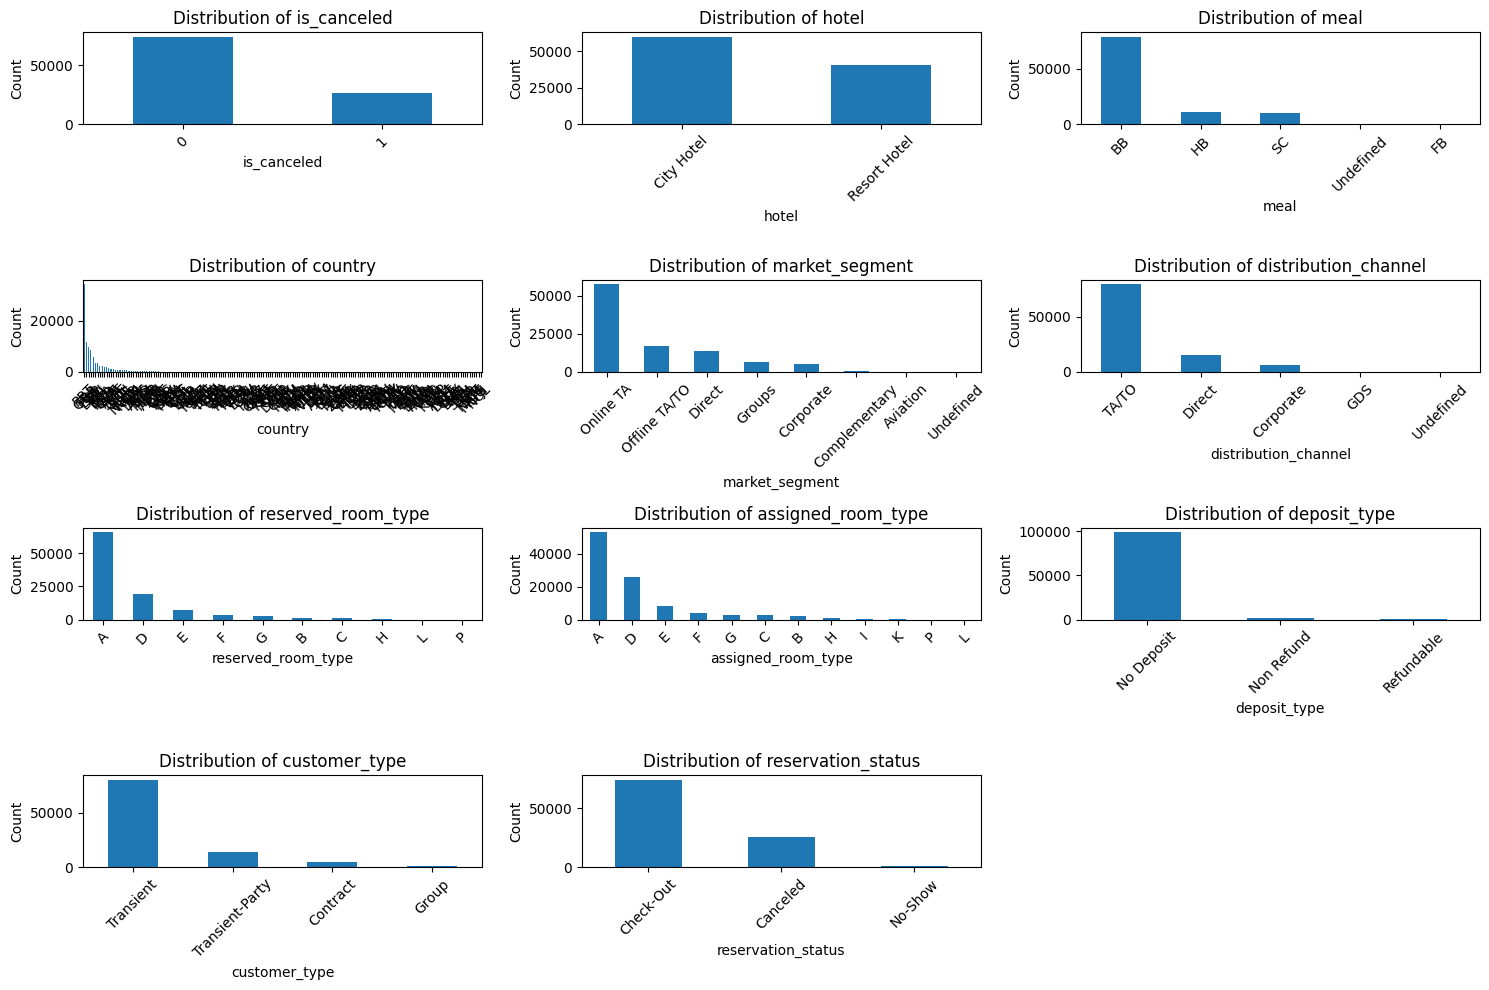

In [21]:
# Define the categorical variables
categorical_vars = ["is_canceled", "hotel", "meal", "country", "market_segment",
                    "distribution_channel", "reserved_room_type", "assigned_room_type", 
                    "deposit_type", "customer_type", "reservation_status"]

# Determine the number of required rows and columns for subplots
num_vars = len(categorical_vars)

# Create the subplots
fig, axes = plt.subplots(4, 3, figsize=(15,10))

# Generate bar charts for each categorical variable
for i, var in enumerate(categorical_vars):
    row = i // 3  # Calculate the row index
    col = i % 3  # Calculate the column index
    hotel_df1[var].value_counts().plot(kind='bar', ax=axes[row, col])
    axes[row, col].set_title(f"Distribution of {var}")
    axes[row, col].set_xlabel(var)
    axes[row, col].set_ylabel("Count")
    axes[row, col].tick_params(axis='x', rotation=45)  # Rotate x-axis labels if necessary

# Remove any empty subplots in the last row if needed
if num_vars % 3 != 0:
    for j in range(num_vars % 3, 3):
        fig.delaxes(axes[-1, j])

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

There are more check out than canceled hotel reservations.

City hotels seems to attract most clients.

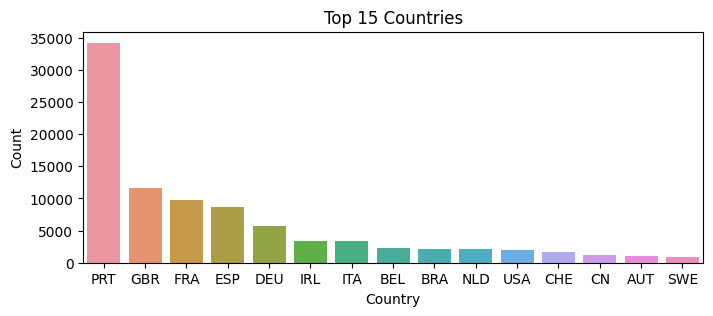

In [22]:
# visualize top 10 country 
top_10_countries = hotel_df1['country'].value_counts().nlargest(15)
plt.figure(figsize=(8,3))
sns.countplot(x='country', data=hotel_df1, order=top_10_countries.index)
plt.title('Top 15 Countries')
plt.xlabel('Country')
plt.ylabel('Count')
plt.show()

Most of the clients are from Portugal.

<h5> Visualizing numerical columns

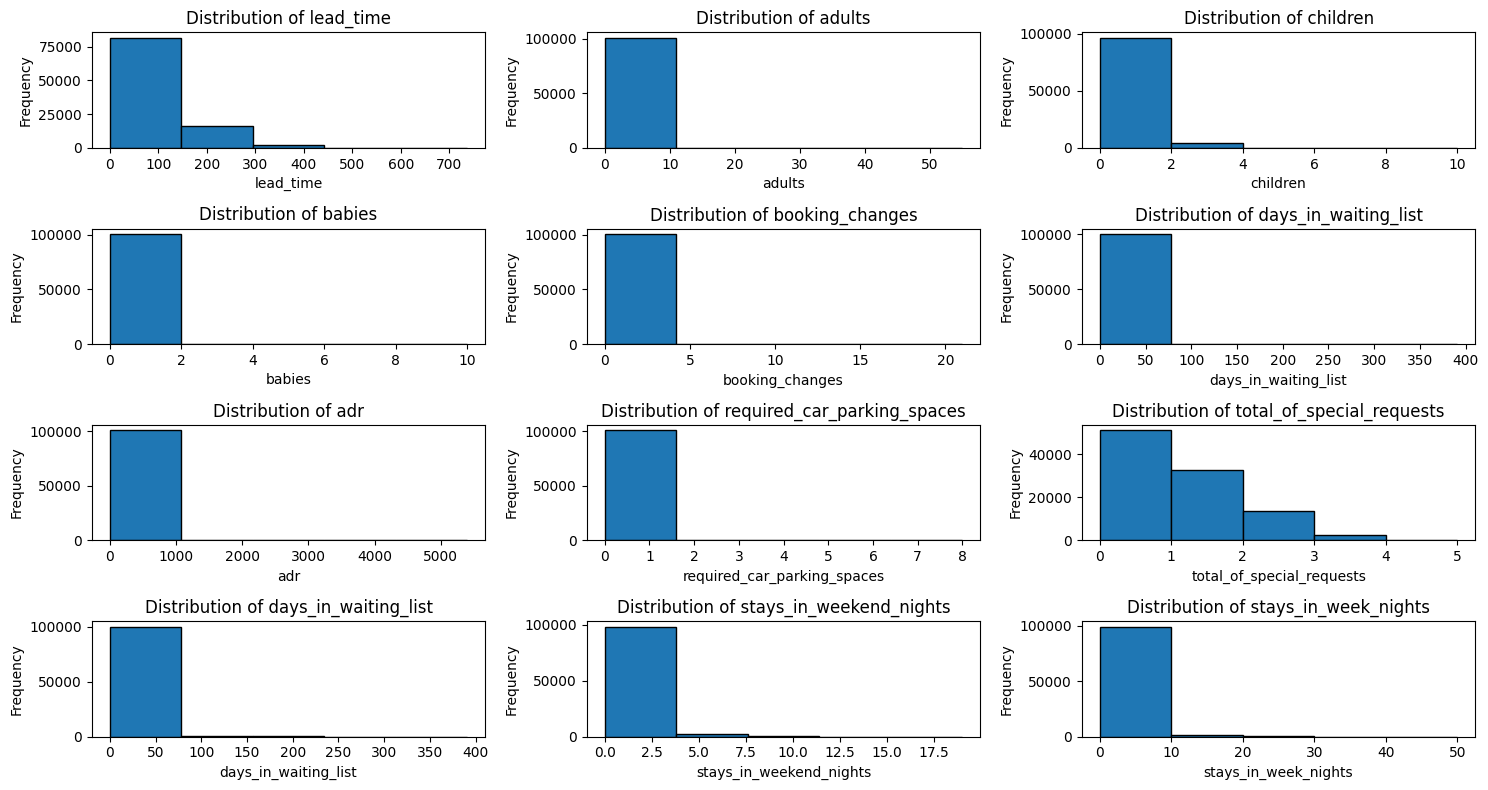

In [23]:
# definining numerical columns in the data
numerical_vars = ["lead_time", "adults", "children", "babies", "booking_changes",
                  "days_in_waiting_list", "adr", "required_car_parking_spaces", "total_of_special_requests",
                  "days_in_waiting_list","stays_in_weekend_nights","stays_in_week_nights"]

# Create subplots for each numerical variable
fig, axes = plt.subplots(4, 3, figsize=(15, 8))

# Generate histograms for each numerical variable
for i, var in enumerate(numerical_vars):
    row = i // 3  # Calculate the row index
    col = i % 3  # Calculate the column index
    hotel_df1[var].plot(kind='hist', ax=axes[row, col], bins=5, edgecolor='black')
    axes[row, col].set_title(f"Distribution of {var}")
    axes[row, col].set_xlabel(var)
    axes[row, col].set_ylabel("Frequency")

# Hide empty subplots
if i+1 < len(numerical_vars):
    for j in range(i+1, len(numerical_vars)):
        row = j // 3
        col = j % 3
        fig.delaxes(axes[row, col])

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

- Our data seems to has some outliers and is highly skewed to the right.

<h5> Trends analysis

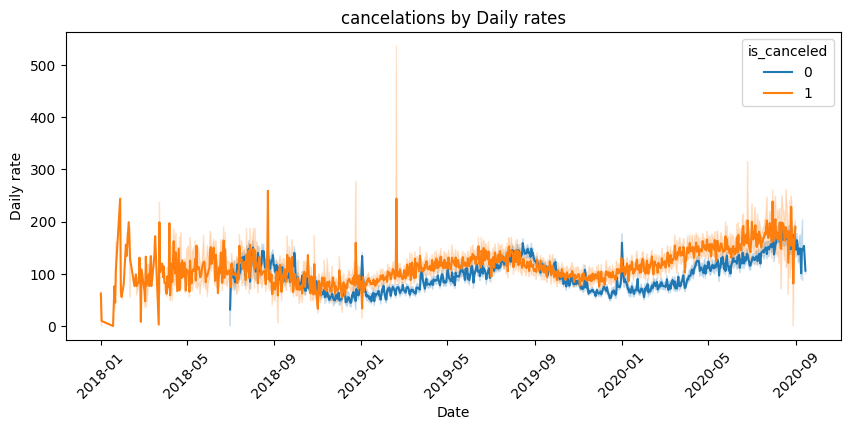

In [24]:
plt.figure(figsize=(10,4))
sns.lineplot(x='reservation_status_date', y='adr', hue='is_canceled', data=hotel_df1)
plt.title('cancelations by Daily rates')
plt.ylabel('Daily rate')
plt.xlabel('Date')
plt.xticks(rotation=45);

From the above the graph, 
- Canceled reservations appears to increase with increase in prices.
- Most reservations appear to be on the 3rd quarter specically on August.
- There are also observable otliers.

<h5> Relationship

In [25]:
def create_scatterplot(data, x, y, cancelation=0):
    '''
    A function to plot scatter plot to visualize the relationship between
    different numerical columns.
    '''
    # Scatter plot
    plt.figure(figsize=(7,3))
    sns.scatterplot(x=x, y=y, data=data, hue=cancelation)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(f"Cancelation scatter plot: {x} vs {y}")

    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()

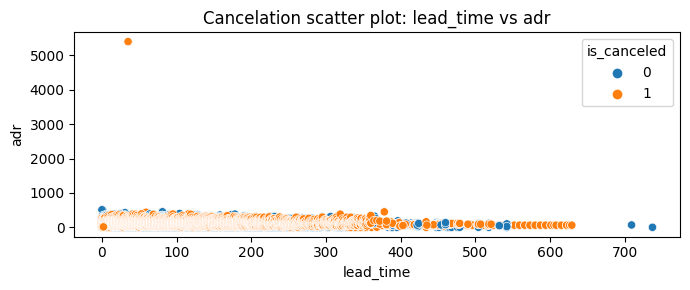

In [26]:
# calling function to plot scatter plot
create_scatterplot(hotel_df1, 'lead_time', 'adr', 'is_canceled')

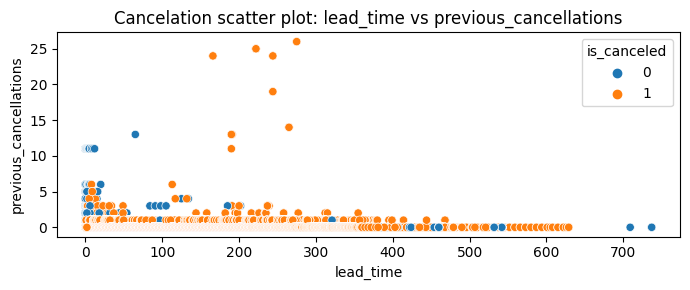

In [27]:
#calling function 
create_scatterplot(hotel_df1, 'lead_time', 'previous_cancellations', 'is_canceled')

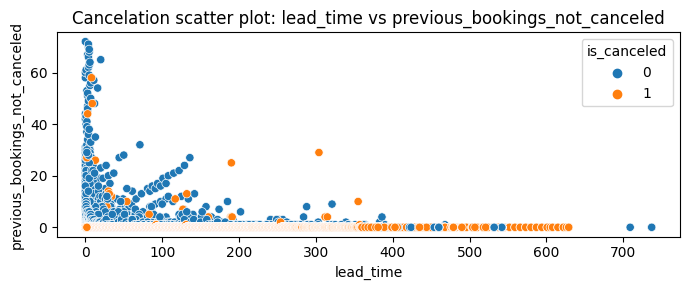

In [28]:
# calling function 
create_scatterplot(hotel_df1, 'lead_time', 'previous_bookings_not_canceled', 'is_canceled')

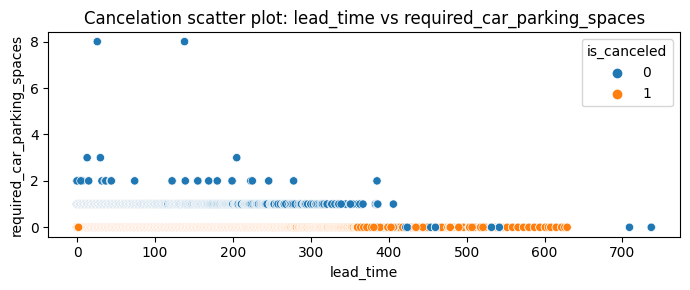

In [29]:
# calling function 
create_scatterplot(hotel_df1, 'lead_time', 'required_car_parking_spaces', 'is_canceled')

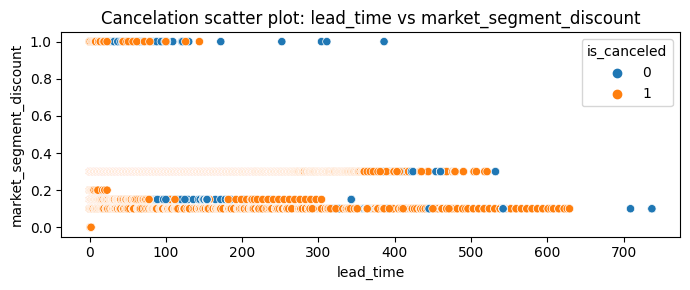

In [30]:
# calling function 
create_scatterplot(hotel_df1, 'lead_time', 'market_segment_discount', 'is_canceled')

Observations:
- Cancellation tends to increase with increase in lead time.
- Hotel booking cancellations tends to increase with increase in number of previous cancellations.
- There is no evidence that increase in required car parking spaces would lead to cancellation.
- As discount increase seems the number of people who din't cancel increased.
- There are outliers in our dataset.

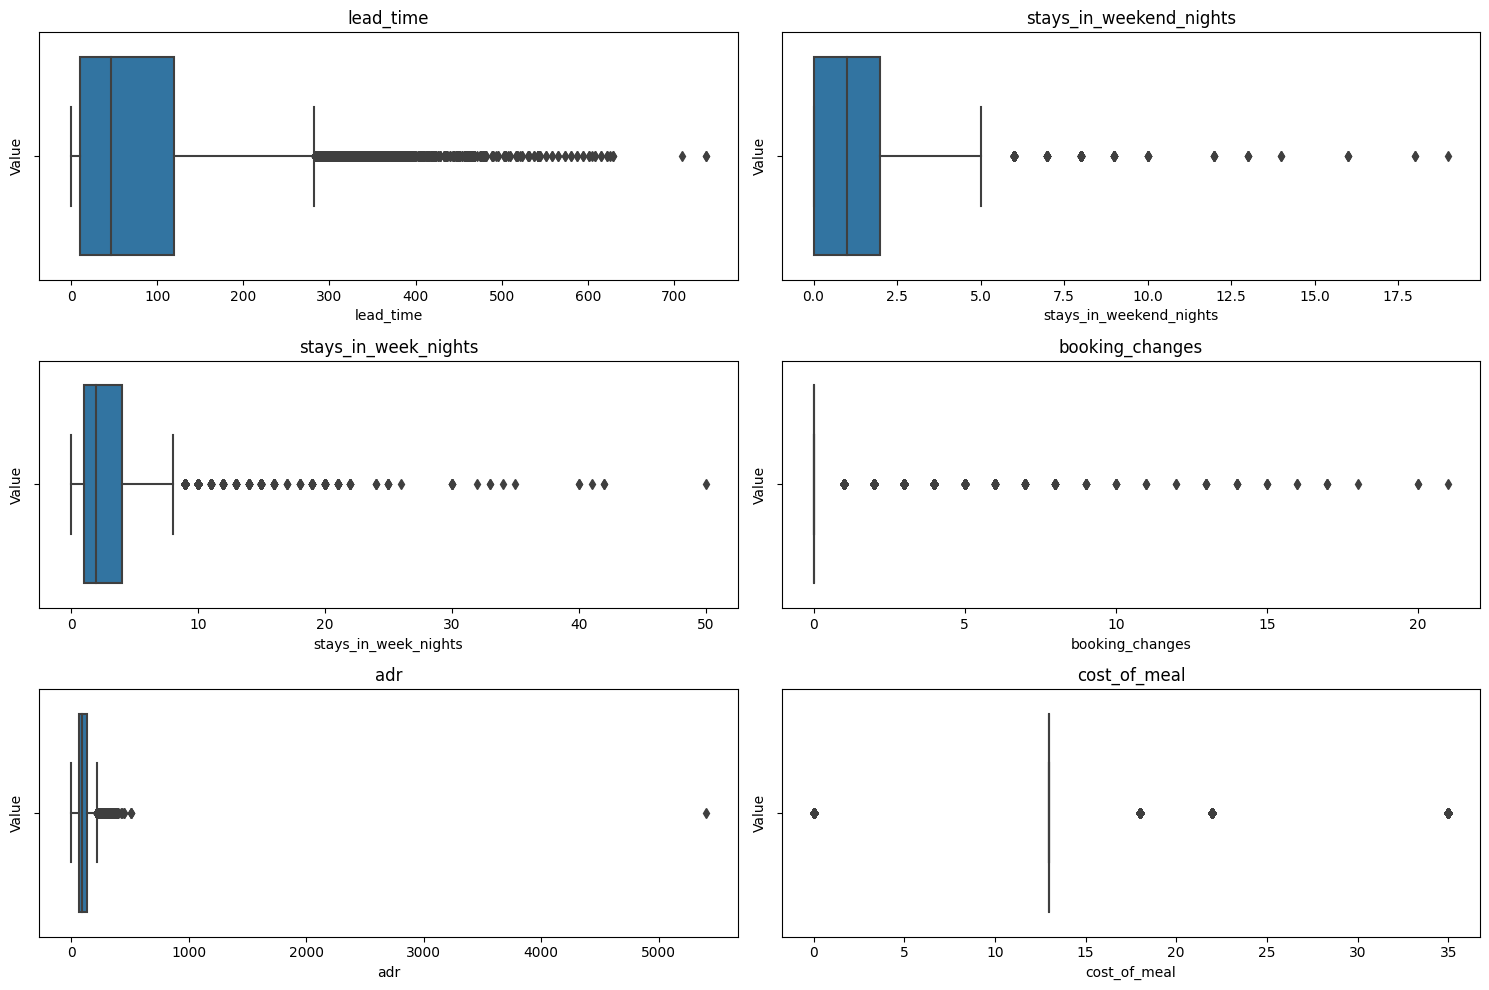

In [31]:
variables = ["lead_time", "stays_in_weekend_nights", "stays_in_week_nights", "booking_changes", "adr", "cost_of_meal"]

# Create subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 10))

# Generate box plots for each variable
for i, var in enumerate(variables):
    row = i // 2  # Calculate the row index
    col = i % 2  # Calculate the column index
    sns.boxplot(x=hotel_df1[var], ax=axes[row, col])
    axes[row, col].set_xlabel(var)
    axes[row, col].set_ylabel("Value")
    axes[row, col].set_title(f"{var}")

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

Question 1: 
What factors influence hotel reservation cancellations?

In [32]:
def countplot(data, x, canceled):
    plt.figure(figsize=(10,4))
    ax = sns.countplot(data=data, x=x, hue=canceled)
    plt.title(f"Cancelation Distribution by {x}")

    total = len(data[x])
    for p in ax.patches:
        height = p.get_height()
        percentage = height / total * 100
        ax.text(p.get_x() + p.get_width() / 2, height, f'{percentage:.2f}%', ha='center', va='bottom')

    plt.show()

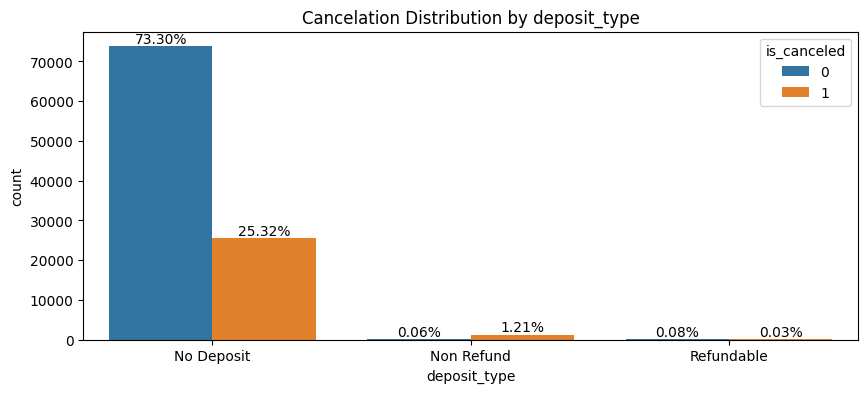

In [33]:
# pass the function to  visualize the propotion of cancelations by deposit type.
countplot(hotel_df1,'deposit_type','is_canceled')

Observation:
- Customers tend to cancel more where there are non refundable deposits.

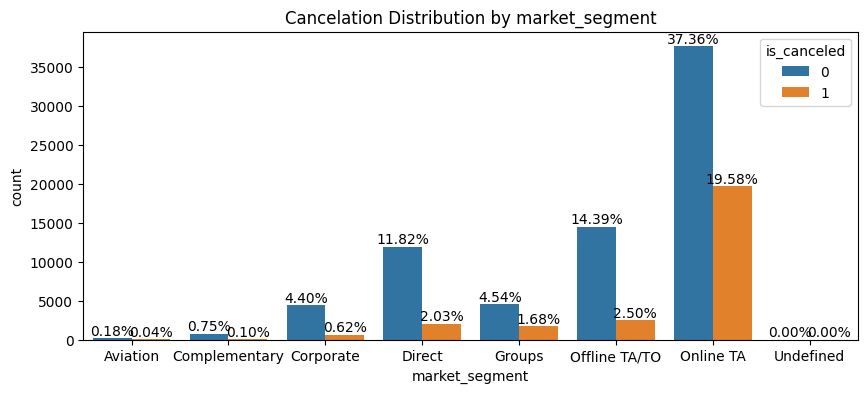

In [34]:
# pass the function to  visualize the propotion of cancelations by market segment.
countplot(hotel_df1,'market_segment','is_canceled')

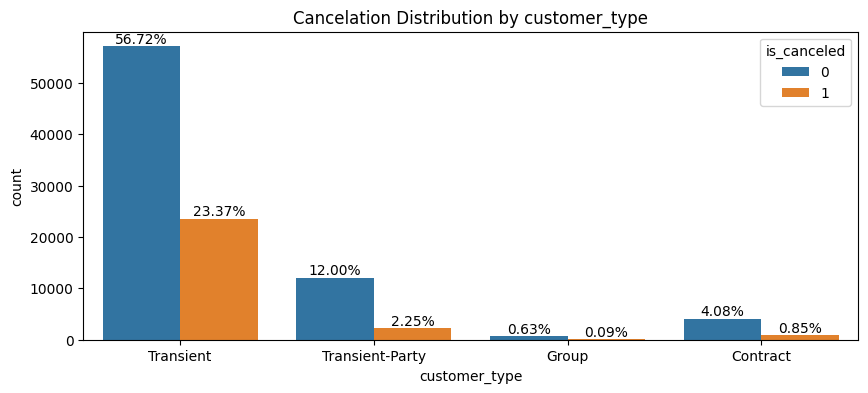

In [35]:
# pass the function to  visualize the propotion of cancelations by customer type.
countplot(hotel_df1,'customer_type','is_canceled')

Findings
- There is not enough evidence to conclude that cancellation is impacted by the customer type or market segment; hence, we need to carry out further statistical tests to conclude this.
- The percentage of hotel cancellations where deposits are higher compared to non-cancellations. Thereore, chances are deposits are making clients cancel the reservations.

Question 2: How can hotels improve their reservation processes to reduce cancellation rates and enhance customer satisfaction?

To improve reservation processes, the hotels can;
1. Work on reducing the lead time.
2. Remove or consinder lowering hotel deposits, especially for the online TA which seems to have the highest traffic and offer more discount to their clients.

Question 3: - How can hotels optimize their pricing and promotion strategies to minimize cancellations and maximize revenue?
 - Tailor campaigns for promotions to specific customer segments, and customer type.
 - Implementing loyalty programs to retain loyal customers.
 - Have a flexible pricing based on room demands, especially the first quarter which has the highest rates of cancellations.

Assumptions:
- Cancellations happen when prices rise.
- Customers are likely to cancel when lead takes too long.
- Cancellations happen when there is a deposit.

<h5> Modeling


*I will buid a model to predict customer cancellations.*
- Our target variable will be is_canceled. I am going to select the best features that can predict cancelletion from our columns.

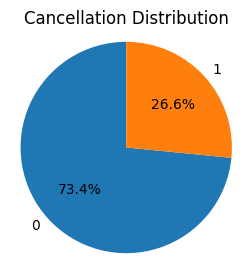

In [36]:
# visualizing class distribution (is_cancelled)
cancel_counts = hotel_df1['is_canceled'].value_counts()

# Create a pie chart using matplotlib
plt.figure(figsize=(3, 3))
plt.pie(cancel_counts, labels=cancel_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Cancellation Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

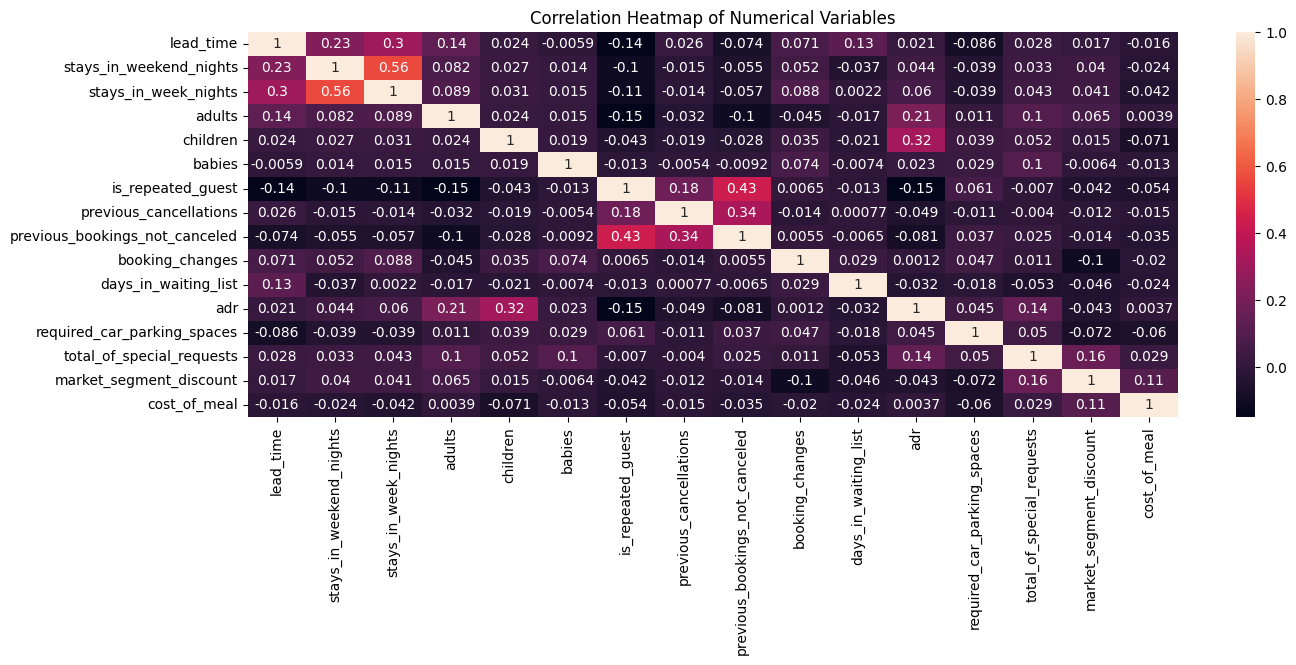

In [37]:
# Select the numerical columns from the dataframe
numerical_vars = hotel_df1.select_dtypes(include='number')

# Calculate the correlation matrix
correlation_matrix = numerical_vars.corr()

# plot heatmap
plt.figure(figsize=(15,5))
sns.heatmap(correlation_matrix, annot=True)
plt.title('Correlation Heatmap of Numerical Variables')
plt.show()


There is very little correlation among the featrures

<h5> Returning important features.

In [38]:
hotel_df1.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date',
       'market_segment_discount', 'cost_of_meal'],
      dtype='object')

In [39]:
# return columns relevant columns for modeling
model_df= hotel_df1.drop(columns={'reservation_status', 'reservation_status_date'})

# drop the 8 null rows in children
model_df.dropna(subset=['children'], inplace=True)

# check for nulls
model_df.isna().any()

hotel                             False
is_canceled                       False
lead_time                         False
arrival_date_year                 False
arrival_date_month                False
arrival_date_week_number          False
arrival_date_day_of_month         False
stays_in_weekend_nights           False
stays_in_week_nights              False
adults                            False
children                          False
babies                            False
meal                              False
country                           False
market_segment                    False
distribution_channel              False
is_repeated_guest                 False
previous_cancellations            False
previous_bookings_not_canceled    False
reserved_room_type                False
assigned_room_type                False
booking_changes                   False
deposit_type                      False
days_in_waiting_list              False
customer_type                     False


In [40]:
# spliting data to train and test set.
# Defining features and target variable
X = model_df.drop('is_canceled', axis=1)  # Features
y = model_df['is_canceled'].astype('int') # Target variable

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shape of the train and test sets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (80578, 29)
y_train shape: (80578,)
X_test shape: (20145, 29)
y_test shape: (20145,)


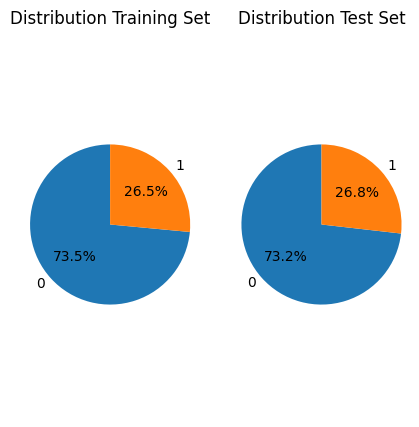

In [41]:

# Calculate class distribution in training set
train_distribution = y_train.value_counts(normalize=True) * 100

# Calculate class distribution in test set
test_distribution = y_test.value_counts(normalize=True) * 100

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(5, 5))

# Plot pie chart for training set
axes[0].pie(train_distribution, labels=train_distribution.index, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Distribution Training Set')

# Plot pie chart for test set
axes[1].pie(test_distribution, labels=test_distribution.index, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Distribution Test Set')

# Equal aspect ratio ensures that pie charts are drawn as circles
axes[0].axis('equal')
axes[1].axis('equal')

# Display the pie charts
plt.show()

In [53]:
def CMatrix(CM, labels=['check_out','cancelled']):
  df = pd.DataFrame(data=CM, index=labels, columns=labels)
  df.index.name = 'TRUE'
  df.columns.name = 'PREDICTION'
  df.loc['Total'] = df.sum()
  df['Total'] = df.sum(axis=1)
  return df

Model

In [76]:
# Separate numeric and categorical columns
numeric_cols = X_train.select_dtypes(include=['float', 'int']).columns
categorical_cols = X_train.select_dtypes(include=['object']).columns

# Create transformers for imputing missing values and one-hot encoding
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
numeric_transformer = RobustScaler()

X_GBOOST

In [77]:
# creating pipeline
pipeline = Pipeline(steps=[('preprocessor', ColumnTransformer(transformers=[
        ('numeric', numeric_transformer, numeric_cols),
        ('categorical', categorical_transformer, categorical_cols)
    ])), ('estimator', xgb.XGBClassifier())])

pipeline.fit(X_train, y_train)

pipeline.fit(X_train, y_train)

y_pred =pipeline.predict(X_train)
print('Confusion Matrix - Training Set')
display(CMatrix(confusion_matrix(y_train, y_pred)))
print(classification_report(y_train, y_pred))
print('f1 score:', f1_score(y_train, y_pred))

y_pred = pipeline.predict(X_test)
print()
print('Confusion Matrix - Testing Set')
print(CMatrix(confusion_matrix(y_test, y_pred)))
print(classification_report(y_test, y_pred))
print('f1 score:', f1_score(y_test, y_pred))

Confusion Matrix - Training Set


PREDICTION,check_out,cancelled,Total
TRUE,,,
check_out,55298,3935,59233
cancelled,6514,14831,21345
Total,61812,18766,80578


              precision    recall  f1-score   support

           0       0.89      0.93      0.91     59233
           1       0.79      0.69      0.74     21345

    accuracy                           0.87     80578
   macro avg       0.84      0.81      0.83     80578
weighted avg       0.87      0.87      0.87     80578

f1 score: 0.7394978933459649

Confusion Matrix - Testing Set
PREDICTION  check_out  cancelled  Total
TRUE                                   
check_out       13582       1164  14746
cancelled        1901       3498   5399
Total           15483       4662  20145
              precision    recall  f1-score   support

           0       0.88      0.92      0.90     14746
           1       0.75      0.65      0.70      5399

    accuracy                           0.85     20145
   macro avg       0.81      0.78      0.80     20145
weighted avg       0.84      0.85      0.84     20145

f1 score: 0.6953583142828745


Random Forest classifier

In [78]:
pipeline = Pipeline(steps=[('preprocessor', ColumnTransformer(transformers=[
        ('numeric', numeric_transformer, numeric_cols),
        ('categorical', categorical_transformer, categorical_cols)
    ])), ('estimator', RandomForestClassifier())])

pipeline.fit(X_train, y_train)

pipeline.fit(X_train, y_train)

y_pred =pipeline.predict(X_train)
print('Confusion Matrix - Training Set')
display(CMatrix(confusion_matrix(y_train, y_pred)))
print(classification_report(y_train, y_pred))
print('f1 score:', f1_score(y_train, y_pred))

y_pred = pipeline.predict(X_test)
print()
print('Confusion Matrix - Testing Set')
print(CMatrix(confusion_matrix(y_test, y_pred)))
print(classification_report(y_test, y_pred))
print('f1 score:', f1_score(y_test, y_pred))

Confusion Matrix - Training Set


PREDICTION,check_out,cancelled,Total
TRUE,,,
check_out,59150,83,59233
cancelled,138,21207,21345
Total,59288,21290,80578


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59233
           1       1.00      0.99      0.99     21345

    accuracy                           1.00     80578
   macro avg       1.00      1.00      1.00     80578
weighted avg       1.00      1.00      1.00     80578

f1 score: 0.9948164653453735

Confusion Matrix - Testing Set
PREDICTION  check_out  cancelled  Total
TRUE                                   
check_out       13905        841  14746
cancelled        1944       3455   5399
Total           15849       4296  20145
              precision    recall  f1-score   support

           0       0.88      0.94      0.91     14746
           1       0.80      0.64      0.71      5399

    accuracy                           0.86     20145
   macro avg       0.84      0.79      0.81     20145
weighted avg       0.86      0.86      0.86     20145

f1 score: 0.7127385250128933


DecisionTree

In [79]:
pipeline = Pipeline(steps=[('preprocessor', ColumnTransformer(transformers=[
        ('numeric', numeric_transformer, numeric_cols),
        ('categorical', categorical_transformer, categorical_cols)
    ])), ('estimator', DecisionTreeClassifier())])

pipeline.fit(X_train, y_train)

pipeline.fit(X_train, y_train)

y_pred =pipeline.predict(X_train)
print('Confusion Matrix - Training Set')
display(CMatrix(confusion_matrix(y_train, y_pred)))
print(classification_report(y_train, y_pred))
print('f1 score:', f1_score(y_train, y_pred))

y_pred = pipeline.predict(X_test)
print()
print('Confusion Matrix - Testing Set')
print(CMatrix(confusion_matrix(y_test, y_pred)))
print(classification_report(y_test, y_pred))
print('f1 score:', f1_score(y_test, y_pred))

Confusion Matrix - Training Set


PREDICTION,check_out,cancelled,Total
TRUE,,,
check_out,59204,29,59233
cancelled,192,21153,21345
Total,59396,21182,80578


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59233
           1       1.00      0.99      0.99     21345

    accuracy                           1.00     80578
   macro avg       1.00      1.00      1.00     80578
weighted avg       1.00      1.00      1.00     80578

f1 score: 0.9948033014320313

Confusion Matrix - Testing Set
PREDICTION  check_out  cancelled  Total
TRUE                                   
check_out       12983       1763  14746
cancelled        1830       3569   5399
Total           14813       5332  20145
              precision    recall  f1-score   support

           0       0.88      0.88      0.88     14746
           1       0.67      0.66      0.67      5399

    accuracy                           0.82     20145
   macro avg       0.77      0.77      0.77     20145
weighted avg       0.82      0.82      0.82     20145

f1 score: 0.6651756593048178


AdaBoost

In [80]:
pipeline = Pipeline(steps=[('preprocessor', ColumnTransformer(transformers=[
        ('numeric', numeric_transformer, numeric_cols),
        ('categorical', categorical_transformer, categorical_cols)
    ])), ('estimator', AdaBoostClassifier())])

pipeline.fit(X_train, y_train)

pipeline.fit(X_train, y_train)

y_pred =pipeline.predict(X_train)
print('Confusion Matrix - Training Set')
display(CMatrix(confusion_matrix(y_train, y_pred)))
print(classification_report(y_train, y_pred))
print('f1 score:', f1_score(y_train, y_pred))

y_pred = pipeline.predict(X_test)
print()
print('Confusion Matrix - Testing Set')
print(CMatrix(confusion_matrix(y_test, y_pred)))
print(classification_report(y_test, y_pred))
print('f1 score:', f1_score(y_test, y_pred))

Confusion Matrix - Training Set


PREDICTION,check_out,cancelled,Total
TRUE,,,
check_out,54821,4412,59233
cancelled,10540,10805,21345
Total,65361,15217,80578


              precision    recall  f1-score   support

           0       0.84      0.93      0.88     59233
           1       0.71      0.51      0.59     21345

    accuracy                           0.81     80578
   macro avg       0.77      0.72      0.74     80578
weighted avg       0.80      0.81      0.80     80578

f1 score: 0.5910508177889613

Confusion Matrix - Testing Set
PREDICTION  check_out  cancelled  Total
TRUE                                   
check_out       13667       1079  14746
cancelled        2682       2717   5399
Total           16349       3796  20145
              precision    recall  f1-score   support

           0       0.84      0.93      0.88     14746
           1       0.72      0.50      0.59      5399

    accuracy                           0.81     20145
   macro avg       0.78      0.72      0.74     20145
weighted avg       0.80      0.81      0.80     20145

f1 score: 0.590973355084285


GradientBoostingClassifier

In [81]:
pipeline = Pipeline(steps=[('preprocessor', ColumnTransformer(transformers=[
        ('numeric', numeric_transformer, numeric_cols),
        ('categorical', categorical_transformer, categorical_cols)
    ])), ('estimator', GradientBoostingClassifier())])
    
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_train)
print('Confusion Matrix - Training Set')
display(CMatrix(confusion_matrix(y_train, y_pred)))
print(classification_report(y_train, y_pred))
print('f1 score:', f1_score(y_train, y_pred))

y_pred = pipeline.predict(X_test)
print()
print('Confusion Matrix - Testing Set')
print(CMatrix(confusion_matrix(y_test, y_pred)))
print(classification_report(y_test, y_pred))
print('f1 score:', f1_score(y_test, y_pred))

Confusion Matrix - Training Set


PREDICTION,check_out,cancelled,Total
TRUE,,,
check_out,55031,4202,59233
cancelled,9528,11817,21345
Total,64559,16019,80578


              precision    recall  f1-score   support

           0       0.85      0.93      0.89     59233
           1       0.74      0.55      0.63     21345

    accuracy                           0.83     80578
   macro avg       0.80      0.74      0.76     80578
weighted avg       0.82      0.83      0.82     80578

f1 score: 0.6325339899368376

Confusion Matrix - Testing Set
PREDICTION  check_out  cancelled  Total
TRUE                                   
check_out       13720       1026  14746
cancelled        2452       2947   5399
Total           16172       3973  20145
              precision    recall  f1-score   support

           0       0.85      0.93      0.89     14746
           1       0.74      0.55      0.63      5399

    accuracy                           0.83     20145
   macro avg       0.80      0.74      0.76     20145
weighted avg       0.82      0.83      0.82     20145

f1 score: 0.628894579598805


Logistic regression

In [82]:
pipeline = Pipeline(steps=[('preprocessor', ColumnTransformer(transformers=[
        ('numeric', numeric_transformer, numeric_cols),
        ('categorical', categorical_transformer, categorical_cols)
    ])), ('estimator', LogisticRegression())])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_train)
print('Confusion Matrix - Training Set')
display(CMatrix(confusion_matrix(y_train, y_pred)))
print(classification_report(y_train, y_pred))
print('f1 score:', f1_score(y_train, y_pred))

y_pred = pipeline.predict(X_test)
print()
print('Confusion Matrix - Testing Set')
print(CMatrix(confusion_matrix(y_test, y_pred)))
print(classification_report(y_test, y_pred))
print('f1 score:', f1_score(y_test, y_pred))

Confusion Matrix - Training Set


PREDICTION,check_out,cancelled,Total
TRUE,,,
check_out,54661,4572,59233
cancelled,11028,10317,21345
Total,65689,14889,80578


              precision    recall  f1-score   support

           0       0.83      0.92      0.88     59233
           1       0.69      0.48      0.57     21345

    accuracy                           0.81     80578
   macro avg       0.76      0.70      0.72     80578
weighted avg       0.80      0.81      0.79     80578

f1 score: 0.5694651432356351

Confusion Matrix - Testing Set
PREDICTION  check_out  cancelled  Total
TRUE                                   
check_out       13621       1125  14746
cancelled        2780       2619   5399
Total           16401       3744  20145
              precision    recall  f1-score   support

           0       0.83      0.92      0.87     14746
           1       0.70      0.49      0.57      5399

    accuracy                           0.81     20145
   macro avg       0.77      0.70      0.72     20145
weighted avg       0.80      0.81      0.79     20145

f1 score: 0.5728972984797113


hyperparametor tuning random forest

In [88]:
pipeline = Pipeline(steps=[('preprocessor', ColumnTransformer(transformers=[
        ('numeric', numeric_transformer, numeric_cols),
        ('categorical', categorical_transformer, categorical_cols)
    ])), ('estimator', RandomForestClassifier(criterion='gini',n_estimators=200, 
                                              class_weight='balanced',max_features='sqrt',max_depth=20))
                                              
])

pipeline.fit(X_train, y_train)

pipeline.fit(X_train, y_train)

y_pred =pipeline.predict(X_train)
print('Confusion Matrix - Training Set')
display(CMatrix(confusion_matrix(y_train, y_pred)))
print(classification_report(y_train, y_pred))
print('f1 score:', f1_score(y_train, y_pred))

y_pred = pipeline.predict(X_test)
print()
print('Confusion Matrix - Testing Set')
print(CMatrix(confusion_matrix(y_test, y_pred)))
print(classification_report(y_test, y_pred))
print('f1 score:', f1_score(y_test, y_pred))

Confusion Matrix - Training Set


PREDICTION,check_out,cancelled,Total
TRUE,,,
check_out,48352,10881,59233
cancelled,1464,19881,21345
Total,49816,30762,80578


              precision    recall  f1-score   support

           0       0.97      0.82      0.89     59233
           1       0.65      0.93      0.76     21345

    accuracy                           0.85     80578
   macro avg       0.81      0.87      0.82     80578
weighted avg       0.88      0.85      0.85     80578

f1 score: 0.7630836547872647

Confusion Matrix - Testing Set
PREDICTION  check_out  cancelled  Total
TRUE                                   
check_out       11676       3070  14746
cancelled         921       4478   5399
Total           12597       7548  20145
              precision    recall  f1-score   support

           0       0.93      0.79      0.85     14746
           1       0.59      0.83      0.69      5399

    accuracy                           0.80     20145
   macro avg       0.76      0.81      0.77     20145
weighted avg       0.84      0.80      0.81     20145

f1 score: 0.6917432609871011


In [92]:
pipeline = Pipeline(steps=[('preprocessor', ColumnTransformer(transformers=[
        ('numeric', numeric_transformer, numeric_cols),
        ('categorical', categorical_transformer, categorical_cols)
    ])), ('estimator', RandomForestClassifier(n_estimators=200,class_weight='balanced',
                                              max_features='sqrt', max_samples= 0.4, min_samples_leaf=5,))
                                              
])

pipeline.fit(X_train, y_train)

pipeline.fit(X_train, y_train)

y_pred =pipeline.predict(X_train)
print('Confusion Matrix - Training Set')
display(CMatrix(confusion_matrix(y_train, y_pred)))
print(classification_report(y_train, y_pred))
print('f1 score:', f1_score(y_train, y_pred))

y_pred = pipeline.predict(X_test)
print()
print('Confusion Matrix - Testing Set')
print(CMatrix(confusion_matrix(y_test, y_pred)))
print(classification_report(y_test, y_pred))
print('f1 score:', f1_score(y_test, y_pred))

Confusion Matrix - Training Set


PREDICTION,check_out,cancelled,Total
TRUE,,,
check_out,49613,9620,59233
cancelled,3141,18204,21345
Total,52754,27824,80578


              precision    recall  f1-score   support

           0       0.94      0.84      0.89     59233
           1       0.65      0.85      0.74     21345

    accuracy                           0.84     80578
   macro avg       0.80      0.85      0.81     80578
weighted avg       0.86      0.84      0.85     80578

f1 score: 0.7404665541296346

Confusion Matrix - Testing Set
PREDICTION  check_out  cancelled  Total
TRUE                                   
check_out       12147       2599  14746
cancelled        1076       4323   5399
Total           13223       6922  20145
              precision    recall  f1-score   support

           0       0.92      0.82      0.87     14746
           1       0.62      0.80      0.70      5399

    accuracy                           0.82     20145
   macro avg       0.77      0.81      0.79     20145
weighted avg       0.84      0.82      0.82     20145

f1 score: 0.7017287557828098


In [99]:
pipeline = Pipeline(steps=[('preprocessor', ColumnTransformer(transformers=[
        ('numeric', numeric_transformer, numeric_cols),
        ('categorical', categorical_transformer, categorical_cols)
    ])), ('estimator', RandomForestClassifier(n_estimators=50,class_weight='balanced',
                                              max_features='sqrt', max_samples= 0.8, min_samples_leaf=6,))
                                              
])

pipeline.fit(X_train, y_train)

pipeline.fit(X_train, y_train)

y_pred =pipeline.predict(X_train)
print('Confusion Matrix - Training Set')
display(CMatrix(confusion_matrix(y_train, y_pred)))
print(classification_report(y_train, y_pred))
print('f1 score:', f1_score(y_train, y_pred))

y_pred = pipeline.predict(X_test)
print()
print('Confusion Matrix - Testing Set')
print(CMatrix(confusion_matrix(y_test, y_pred)))
print(classification_report(y_test, y_pred))
print('f1 score:', f1_score(y_test, y_pred))

Confusion Matrix - Training Set


PREDICTION,check_out,cancelled,Total
TRUE,,,
check_out,49728,9505,59233
cancelled,2756,18589,21345
Total,52484,28094,80578


              precision    recall  f1-score   support

           0       0.95      0.84      0.89     59233
           1       0.66      0.87      0.75     21345

    accuracy                           0.85     80578
   macro avg       0.80      0.86      0.82     80578
weighted avg       0.87      0.85      0.85     80578

f1 score: 0.7519974109508686

Confusion Matrix - Testing Set
PREDICTION  check_out  cancelled  Total
TRUE                                   
check_out       12124       2622  14746
cancelled        1035       4364   5399
Total           13159       6986  20145
              precision    recall  f1-score   support

           0       0.92      0.82      0.87     14746
           1       0.62      0.81      0.70      5399

    accuracy                           0.82     20145
   macro avg       0.77      0.82      0.79     20145
weighted avg       0.84      0.82      0.82     20145

f1 score: 0.7047234557932982


hyperparametor tuning xgboost

In [93]:
# min_sumples_split
pipeline = Pipeline(steps=[('preprocessor', ColumnTransformer(transformers=[
        ('numeric', numeric_transformer, numeric_cols),
        ('categorical', categorical_transformer, categorical_cols)
    ])), ('estimator', xgb.XGBClassifier(scale_pos_weight=1/0.75, eval_metric='logloss'))
                                              
])

pipeline.fit(X_train, y_train)

pipeline.fit(X_train, y_train)

y_pred =pipeline.predict(X_train)
print('Confusion Matrix - Training Set')
display(CMatrix(confusion_matrix(y_train, y_pred)))
print(classification_report(y_train, y_pred))
print('f1 score:', f1_score(y_train, y_pred))

y_pred = pipeline.predict(X_test)
print()
print('Confusion Matrix - Testing Set')
print(CMatrix(confusion_matrix(y_test, y_pred)))
print(classification_report(y_test, y_pred))
print('f1 score:', f1_score(y_test, y_pred))

Confusion Matrix - Training Set


PREDICTION,check_out,cancelled,Total
TRUE,,,
check_out,53821,5412,59233
cancelled,5189,16156,21345
Total,59010,21568,80578


              precision    recall  f1-score   support

           0       0.91      0.91      0.91     59233
           1       0.75      0.76      0.75     21345

    accuracy                           0.87     80578
   macro avg       0.83      0.83      0.83     80578
weighted avg       0.87      0.87      0.87     80578

f1 score: 0.7529653018898702

Confusion Matrix - Testing Set
PREDICTION  check_out  cancelled  Total
TRUE                                   
check_out       13222       1524  14746
cancelled        1551       3848   5399
Total           14773       5372  20145
              precision    recall  f1-score   support

           0       0.90      0.90      0.90     14746
           1       0.72      0.71      0.71      5399

    accuracy                           0.85     20145
   macro avg       0.81      0.80      0.81     20145
weighted avg       0.85      0.85      0.85     20145

f1 score: 0.7145111874477763


In [100]:
# min_sumples_split
pipeline = Pipeline(steps=[('preprocessor', ColumnTransformer(transformers=[
        ('numeric', numeric_transformer, numeric_cols),
        ('categorical', categorical_transformer, categorical_cols)
    ])), ('estimator', xgb.XGBClassifier(scale_pos_weight=1/0.70, eval_metric='logloss'))
                                              
])

pipeline.fit(X_train, y_train)

pipeline.fit(X_train, y_train)

y_pred =pipeline.predict(X_train)
print('Confusion Matrix - Training Set')
display(CMatrix(confusion_matrix(y_train, y_pred)))
print(classification_report(y_train, y_pred))
print('f1 score:', f1_score(y_train, y_pred))

y_pred = pipeline.predict(X_test)
print()
print('Confusion Matrix - Testing Set')
print(CMatrix(confusion_matrix(y_test, y_pred)))
print(classification_report(y_test, y_pred))
print('f1 score:', f1_score(y_test, y_pred))

Confusion Matrix - Training Set


PREDICTION,check_out,cancelled,Total
TRUE,,,
check_out,53444,5789,59233
cancelled,4986,16359,21345
Total,58430,22148,80578


              precision    recall  f1-score   support

           0       0.91      0.90      0.91     59233
           1       0.74      0.77      0.75     21345

    accuracy                           0.87     80578
   macro avg       0.83      0.83      0.83     80578
weighted avg       0.87      0.87      0.87     80578

f1 score: 0.7522589842043547

Confusion Matrix - Testing Set
PREDICTION  check_out  cancelled  Total
TRUE                                   
check_out       13118       1628  14746
cancelled        1464       3935   5399
Total           14582       5563  20145
              precision    recall  f1-score   support

           0       0.90      0.89      0.89     14746
           1       0.71      0.73      0.72      5399

    accuracy                           0.85     20145
   macro avg       0.80      0.81      0.81     20145
weighted avg       0.85      0.85      0.85     20145

f1 score: 0.7179346834519248


In [91]:
# min_sumples_split
pipeline = Pipeline(steps=[('preprocessor', ColumnTransformer(transformers=[
        ('numeric', numeric_transformer, numeric_cols),
        ('categorical', categorical_transformer, categorical_cols)
    ])), ('estimator', xgb.XGBClassifier(scale_pos_weight=1/0.65, eval_metric='logloss'))
                                              
])

pipeline.fit(X_train, y_train)

pipeline.fit(X_train, y_train)

y_pred =pipeline.predict(X_train)
print('Confusion Matrix - Training Set')
display(CMatrix(confusion_matrix(y_train, y_pred)))
print(classification_report(y_train, y_pred))
print('f1 score:', f1_score(y_train, y_pred))

y_pred = pipeline.predict(X_test)
print()
print('Confusion Matrix - Testing Set')
print(CMatrix(confusion_matrix(y_test, y_pred)))
print(classification_report(y_test, y_pred))
print('f1 score:', f1_score(y_test, y_pred))

Confusion Matrix - Training Set


PREDICTION,check_out,cancelled,Total
TRUE,,,
check_out,53155,6078,59233
cancelled,4585,16760,21345
Total,57740,22838,80578


              precision    recall  f1-score   support

           0       0.92      0.90      0.91     59233
           1       0.73      0.79      0.76     21345

    accuracy                           0.87     80578
   macro avg       0.83      0.84      0.83     80578
weighted avg       0.87      0.87      0.87     80578

f1 score: 0.758662834121721

Confusion Matrix - Testing Set
PREDICTION  check_out  cancelled  Total
TRUE                                   
check_out       13033       1713  14746
cancelled        1410       3989   5399
Total           14443       5702  20145
              precision    recall  f1-score   support

           0       0.90      0.88      0.89     14746
           1       0.70      0.74      0.72      5399

    accuracy                           0.84     20145
   macro avg       0.80      0.81      0.81     20145
weighted avg       0.85      0.84      0.85     20145

f1 score: 0.7186739933339338


Feature importance

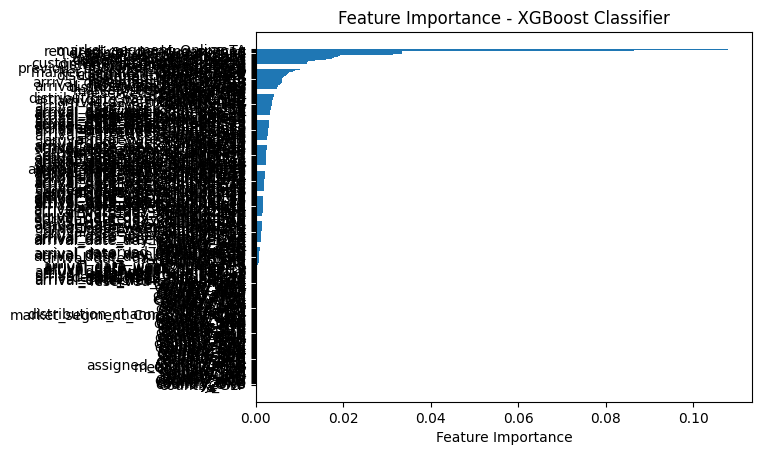

In [110]:
import numpy as np
# Get feature importances from the XGBoost classifier
feature_importances = pipeline.named_steps['estimator'].feature_importances_

# Get the feature names
transformers = pipeline.named_steps['preprocessor'].transformers_
numeric_features = transformers[0][2]
categorical_features = transformers[1][1].get_feature_names_out(categorical_cols)
feature_names = list(numeric_features) + list(categorical_features)

# Create a bar graph for feature importances
fig, ax = plt.subplots()
indices = np.argsort(feature_importances)[::1][10:]
ax.barh(range(len(indices)), feature_importances[indices], align='center')
ax.set_yticks(range(len(indices)))
ax.set_yticklabels([feature_names[i] for i in indices])
ax.set_xlabel('Feature Importance')
ax.set_title('Feature Importance - XGBoost Classifier')
plt.show()

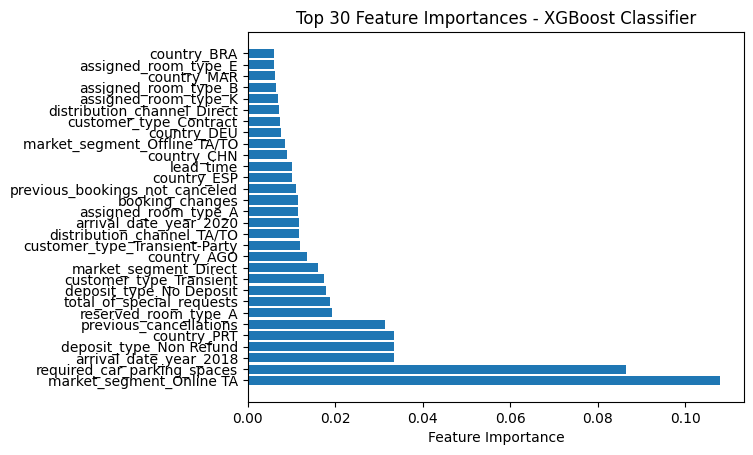

In [116]:
# Get feature importances from the XGBoost classifier
feature_importances = pipeline.named_steps['estimator'].feature_importances_

# Get the feature names
transformers = pipeline.named_steps['preprocessor'].transformers_
numeric_features = transformers[0][2]
categorical_features = transformers[1][1].get_feature_names_out(categorical_cols)
feature_names = list(numeric_features) + list(categorical_features)

# Get the indices of the top 10 features
top_indices = np.argsort(feature_importances)[::-1][:30]

# Get the top 10 feature importances and names
top_importances = feature_importances[top_indices]
top_feature_names = [feature_names[i] for i in top_indices]

# Create a bar graph for feature importances
fig, ax = plt.subplots()
ax.barh(range(len(top_indices)), top_importances, align='center')
ax.set_yticks(range(len(top_indices)))
ax.set_yticklabels(top_feature_names)
ax.set_xlabel('Feature Importance')
ax.set_title('Top 30 Feature Importances - XGBoost Classifier')
plt.show()

From above, arrival_date_year_2018 seems to be a good predictor for check_out or cancelled

In [118]:
hotel_df1.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date',
       'market_segment_discount', 'cost_of_meal'],
      dtype='object')

X_train shape: (43668, 29)
y_train shape: (43668,)
X_test shape: (10918, 29)
y_test shape: (10918,)


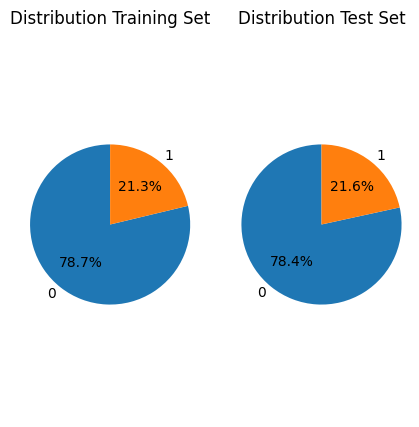

In [124]:
model_df2=hotel_df1[hotel_df1['reservation_status_date'].dt.month >=7]
# model_df2.reservation_status_date.min()
model_df2=model_df2.drop(columns=['reservation_status', 'reservation_status_date'])
# spliting data to train and test set.
# Defining features and target variable
X = model_df2.drop('is_canceled', axis=1)  # Features
y = model_df2['is_canceled'].astype('int') # Target variable

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shape of the train and test sets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Calculate class distribution in training set
train_distribution = y_train.value_counts(normalize=True) * 100

# Calculate class distribution in test set
test_distribution = y_test.value_counts(normalize=True) * 100

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(5, 5))

# Plot pie chart for training set
axes[0].pie(train_distribution, labels=train_distribution.index, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Distribution Training Set')

# Plot pie chart for test set
axes[1].pie(test_distribution, labels=test_distribution.index, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Distribution Test Set')

# Equal aspect ratio ensures that pie charts are drawn as circles
axes[0].axis('equal')
axes[1].axis('equal')

# Display the pie charts
plt.show()

In [125]:
# Separate numeric and categorical columns
numeric_cols = X_train.select_dtypes(include=['float', 'int']).columns
categorical_cols = X_train.select_dtypes(include=['object']).columns

# Create transformers for imputing missing values and one-hot encoding
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
numeric_transformer = RobustScaler()

In [132]:
# min_sumples_split
pipeline = Pipeline(steps=[('preprocessor', ColumnTransformer(transformers=[
        ('numeric', numeric_transformer, numeric_cols),
        ('categorical', categorical_transformer, categorical_cols)
    ])), ('estimator', xgb.XGBClassifier(scale_pos_weight=1/0.70, eval_metric='logloss'))
                                              
])

pipeline.fit(X_train, y_train)

pipeline.fit(X_train, y_train)

y_pred =pipeline.predict(X_train)
print('Confusion Matrix - Training Set')
display(CMatrix(confusion_matrix(y_train, y_pred)))
print(classification_report(y_train, y_pred))
print('f1 score:', f1_score(y_train, y_pred))

y_pred = pipeline.predict(X_test)
print()
print('Confusion Matrix - Testing Set')
print(CMatrix(confusion_matrix(y_test, y_pred)))
print(classification_report(y_test, y_pred))
print('f1 score:', f1_score(y_test, y_pred))

Confusion Matrix - Training Set


PREDICTION,check_out,cancelled,Total
TRUE,,,
check_out,32988,1399,34387
cancelled,2294,6987,9281
Total,35282,8386,43668


              precision    recall  f1-score   support

           0       0.93      0.96      0.95     34387
           1       0.83      0.75      0.79      9281

    accuracy                           0.92     43668
   macro avg       0.88      0.86      0.87     43668
weighted avg       0.91      0.92      0.91     43668

f1 score: 0.7909662081847513

Confusion Matrix - Testing Set
PREDICTION  check_out  cancelled  Total
TRUE                                   
check_out        8072        490   8562
cancelled         750       1606   2356
Total            8822       2096  10918
              precision    recall  f1-score   support

           0       0.91      0.94      0.93      8562
           1       0.77      0.68      0.72      2356

    accuracy                           0.89     10918
   macro avg       0.84      0.81      0.83     10918
weighted avg       0.88      0.89      0.88     10918

f1 score: 0.7214734950584006


In [127]:
# min_sumples_split
pipeline = Pipeline(steps=[('preprocessor', ColumnTransformer(transformers=[
        ('numeric', numeric_transformer, numeric_cols),
        ('categorical', categorical_transformer, categorical_cols)
    ])), ('estimator', xgb.XGBClassifier(scale_pos_weight=1/0.60, eval_metric='logloss'))
                                              
])

pipeline.fit(X_train, y_train)

pipeline.fit(X_train, y_train)

y_pred =pipeline.predict(X_train)
print('Confusion Matrix - Training Set')
display(CMatrix(confusion_matrix(y_train, y_pred)))
print(classification_report(y_train, y_pred))
print('f1 score:', f1_score(y_train, y_pred))

y_pred = pipeline.predict(X_test)
print()
print('Confusion Matrix - Testing Set')
print(CMatrix(confusion_matrix(y_test, y_pred)))
print(classification_report(y_test, y_pred))
print('f1 score:', f1_score(y_test, y_pred))

Confusion Matrix - Training Set


PREDICTION,check_out,cancelled,Total
TRUE,,,
check_out,32597,1790,34387
cancelled,2005,7276,9281
Total,34602,9066,43668


              precision    recall  f1-score   support

           0       0.94      0.95      0.94     34387
           1       0.80      0.78      0.79      9281

    accuracy                           0.91     43668
   macro avg       0.87      0.87      0.87     43668
weighted avg       0.91      0.91      0.91     43668

f1 score: 0.7931541941461819

Confusion Matrix - Testing Set
PREDICTION  check_out  cancelled  Total
TRUE                                   
check_out        8005        557   8562
cancelled         682       1674   2356
Total            8687       2231  10918
              precision    recall  f1-score   support

           0       0.92      0.93      0.93      8562
           1       0.75      0.71      0.73      2356

    accuracy                           0.89     10918
   macro avg       0.84      0.82      0.83     10918
weighted avg       0.88      0.89      0.89     10918

f1 score: 0.7298888162197514


In [128]:
# min_sumples_split
pipeline = Pipeline(steps=[('preprocessor', ColumnTransformer(transformers=[
        ('numeric', numeric_transformer, numeric_cols),
        ('categorical', categorical_transformer, categorical_cols)
    ])), ('estimator', xgb.XGBClassifier(scale_pos_weight=1/0.55, eval_metric='logloss'))
                                              
])

pipeline.fit(X_train, y_train)

pipeline.fit(X_train, y_train)

y_pred =pipeline.predict(X_train)
print('Confusion Matrix - Training Set')
display(CMatrix(confusion_matrix(y_train, y_pred)))
print(classification_report(y_train, y_pred))
print('f1 score:', f1_score(y_train, y_pred))

y_pred = pipeline.predict(X_test)
print()
print('Confusion Matrix - Testing Set')
print(CMatrix(confusion_matrix(y_test, y_pred)))
print(classification_report(y_test, y_pred))
print('f1 score:', f1_score(y_test, y_pred))

Confusion Matrix - Training Set


PREDICTION,check_out,cancelled,Total
TRUE,,,
check_out,32471,1916,34387
cancelled,1847,7434,9281
Total,34318,9350,43668


              precision    recall  f1-score   support

           0       0.95      0.94      0.95     34387
           1       0.80      0.80      0.80      9281

    accuracy                           0.91     43668
   macro avg       0.87      0.87      0.87     43668
weighted avg       0.91      0.91      0.91     43668

f1 score: 0.7980247973807095

Confusion Matrix - Testing Set
PREDICTION  check_out  cancelled  Total
TRUE                                   
check_out        7968        594   8562
cancelled         657       1699   2356
Total            8625       2293  10918
              precision    recall  f1-score   support

           0       0.92      0.93      0.93      8562
           1       0.74      0.72      0.73      2356

    accuracy                           0.89     10918
   macro avg       0.83      0.83      0.83     10918
weighted avg       0.88      0.89      0.88     10918

f1 score: 0.7309098730909873


In [131]:
# min_sumples_split
pipeline = Pipeline(steps=[('preprocessor', ColumnTransformer(transformers=[
        ('numeric', numeric_transformer, numeric_cols),
        ('categorical', categorical_transformer, categorical_cols)
    ])), ('estimator', xgb.XGBClassifier(scale_pos_weight=1/0.50, eval_metric='logloss'))
                                              
])

pipeline.fit(X_train, y_train)

pipeline.fit(X_train, y_train)

y_pred =pipeline.predict(X_train)
print('Confusion Matrix - Training Set')
display(CMatrix(confusion_matrix(y_train, y_pred)))
print(classification_report(y_train, y_pred))
print('f1 score:', f1_score(y_train, y_pred))

y_pred = pipeline.predict(X_test)
print()
print('Confusion Matrix - Testing Set')
print(CMatrix(confusion_matrix(y_test, y_pred)))
print(classification_report(y_test, y_pred))
print('f1 score:', f1_score(y_test, y_pred))

Confusion Matrix - Training Set


PREDICTION,check_out,cancelled,Total
TRUE,,,
check_out,32209,2178,34387
cancelled,1622,7659,9281
Total,33831,9837,43668


              precision    recall  f1-score   support

           0       0.95      0.94      0.94     34387
           1       0.78      0.83      0.80      9281

    accuracy                           0.91     43668
   macro avg       0.87      0.88      0.87     43668
weighted avg       0.92      0.91      0.91     43668

f1 score: 0.8012344387488232

Confusion Matrix - Testing Set
PREDICTION  check_out  cancelled  Total
TRUE                                   
check_out        7897        665   8562
cancelled         610       1746   2356
Total            8507       2411  10918
              precision    recall  f1-score   support

           0       0.93      0.92      0.93      8562
           1       0.72      0.74      0.73      2356

    accuracy                           0.88     10918
   macro avg       0.83      0.83      0.83     10918
weighted avg       0.88      0.88      0.88     10918

f1 score: 0.7325361862806797
